In [71]:
using Pandas
using DataFrames
using PyCall
using PyPlot
pickle = pyimport("pickle")
numpy = pyimport("numpy")

PyObject <module 'numpy' from '/home/fvalle/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/__init__.py'>

In [2]:
function load_pickle(filename)
    @pywith pybuiltin("open")(filename,"rb") as f begin
       data = nothing
       data = pickle.load(f)
       return data
    end
end

load_pickle (generic function with 1 method)

In [3]:
data = load_pickle("data.pkl")

Dict{Any,Any} with 10 entries:
  "var"            => PyObject 0610007P14Rik    0.078030…
  "O"              => PyObject 0610007P14Rik    0.075990…
  "diffWords"      => PyObject Cell_id…
  "heaps_integral" => (6.93379e7, 0.00669541)
  "M"              => PyObject Cell_id…
  "means_nonzero"  => PyObject 0610007P14Rik    1.036145…
  "heaps_fit"      => [4.25923, 0.732378]
  "freq"           => PyObject 0610007P14Rik    9.397300e-05…
  "cv2"            => PyObject 0610007P14Rik      12.586668…
  "means"          => PyObject 0610007P14Rik    0.078737…

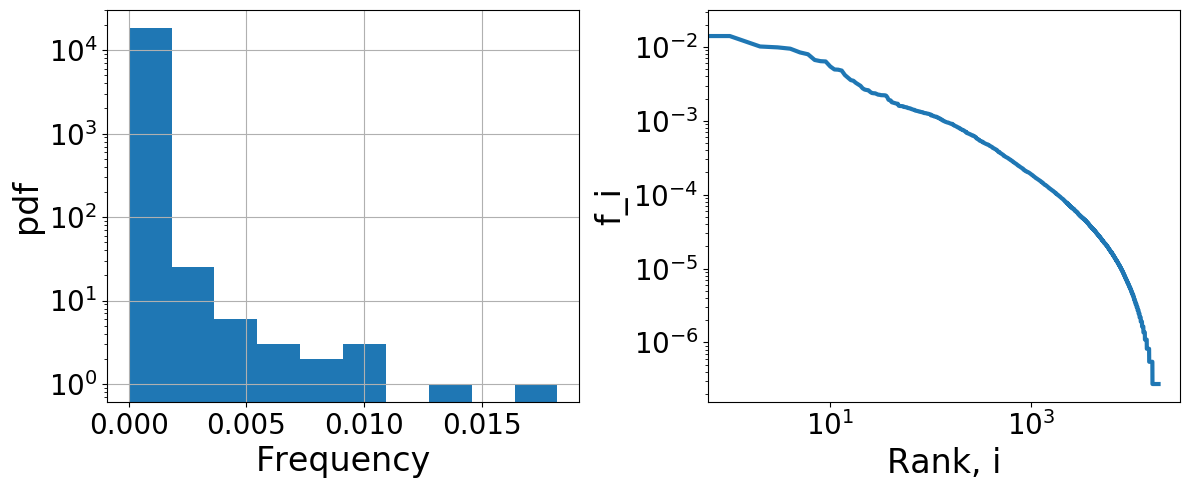

In [4]:
fig, ax = subplots(1,2, figsize=(12,5))
data["freq"].hist(ax=ax[1], bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

f = data["freq"].sort_values(ascending=false)
ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

In [7]:
tissue = "Fetal_Brain"

data = Dict()
data["data"]=load_pickle("data_$(tissue)_data.pkl")
#data["mazzolini"]=load_pickle("data_$(tissue)_mazzolini.pkl")
#data["null_1"]=load_pickle("data_$(tissue)_null_1.pkl")

Dict{Any,Any} with 10 entries:
  "var"            => PyObject 0610007P14Rik    0.078030…
  "O"              => PyObject 0610007P14Rik    0.075990…
  "diffWords"      => PyObject Cell_id…
  "heaps_integral" => (6.93379e7, 0.00669541)
  "M"              => PyObject Cell_id…
  "means_nonzero"  => PyObject 0610007P14Rik    1.036145…
  "heaps_fit"      => [4.25923, 0.732378]
  "freq"           => PyObject 0610007P14Rik    9.397300e-05…
  "cv2"            => PyObject 0610007P14Rik      12.586668…
  "means"          => PyObject 0610007P14Rik    0.078737…

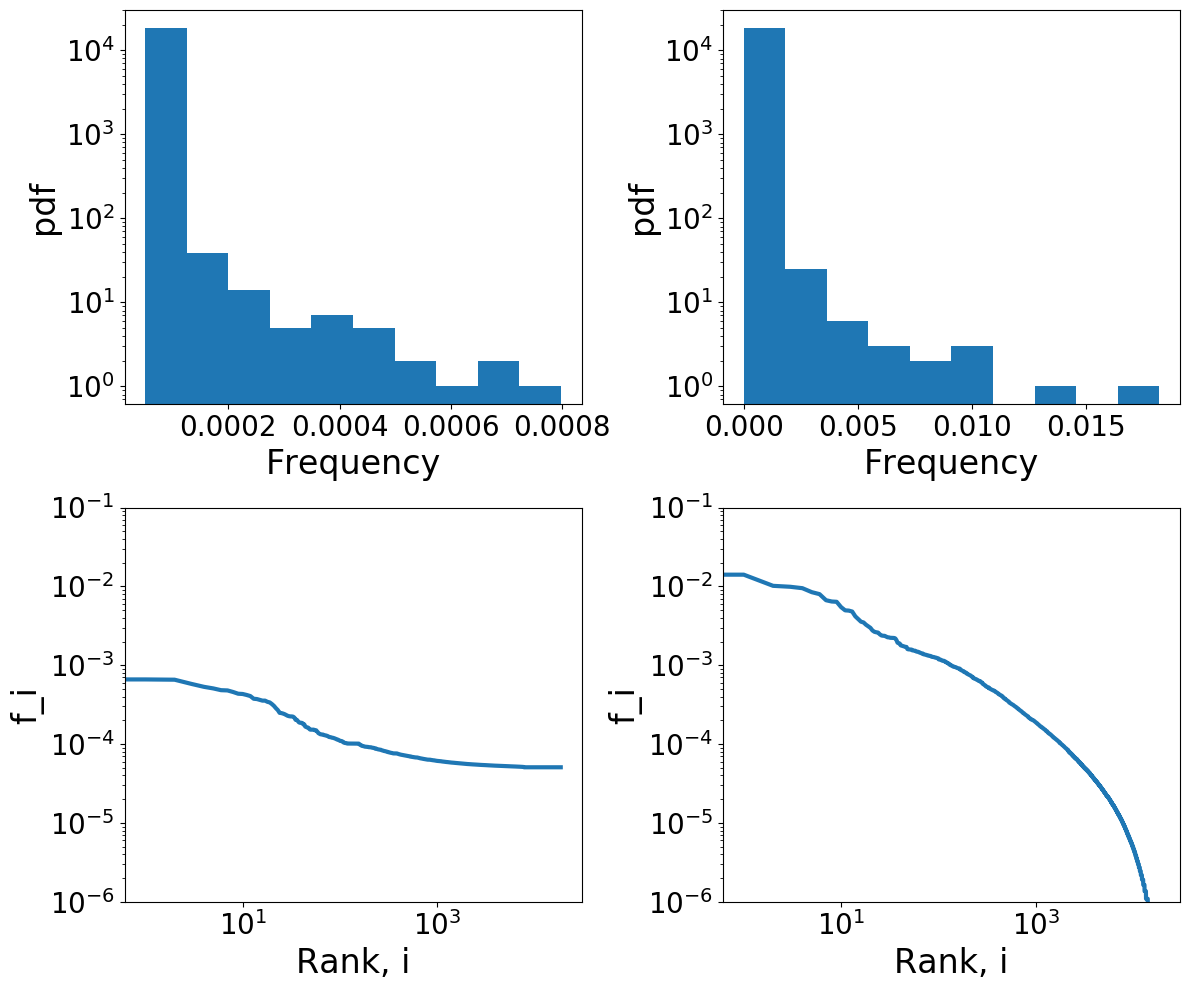

In [8]:
fig, ax = subplots(2,2, figsize=(12,10))
f = data["data"]["means_nonzero"].sort_values(ascending=false)

ax[1].hist(f/f.sum(),  bins=10)
ax[1].set_yscale("log")
ax[1].set_xlabel("Frequency", fontsize=24)
ax[1].set_ylabel("pdf", fontsize=24)

ax[2].plot(f/f.sum())
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_ylim(1e-6,1e-1)
ax[2].set_xlabel("Rank, i", fontsize=24)
ax[2].set_ylabel("f_i", fontsize=24)


f = data["data"]["means"].sort_values(ascending=false)

ax[3].hist(f/f.sum(), bins=10)
ax[3].set_yscale("log")
ax[3].set_xlabel("Frequency", fontsize=24)
ax[3].set_ylabel("pdf", fontsize=24)

ax[4].plot(f/f.sum())
ax[4].set_xscale("log")
ax[4].set_yscale("log")
ax[4].set_ylim(1e-6,1e-1)
ax[4].set_xlabel("Rank, i", fontsize=24)
ax[4].set_ylabel("f_i", fontsize=24)
fig.savefig("f_distribution.pdf")
show()

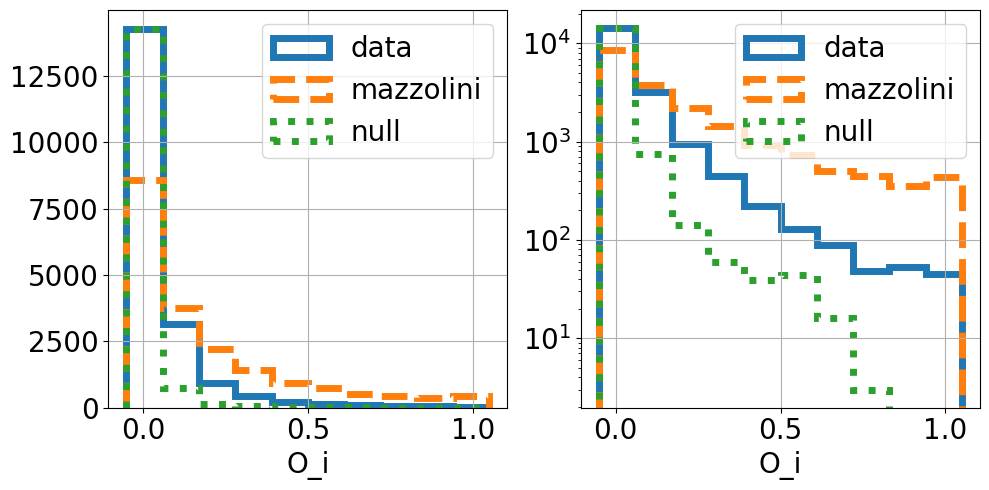

In [77]:
bins=10
rang = (0-0.5/bins, 1+0.5/bins)
fig, ax = subplots(1,2, figsize=(10,5))

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[1], range=rang, bins=bins, ls=":", label="null")

ax[1].legend(fontsize=20)
ax[1].set_xlabel("O_i")

data["data"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, label="data")
data["mazzolini"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls="--", label="mazzolini")
data["null_1"]["O"].hist(histtype="step", lw=5, ax=ax[2], range=rang, bins=bins, ls=":", label="null")

ax[2].set_yscale("log")
ax[2].legend(fontsize=20)
ax[2].set_xlabel("O_i")

fig.savefig("null_1_U.pdf")

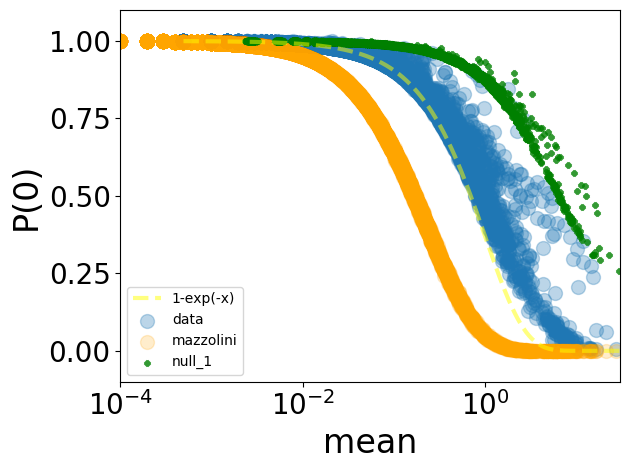

In [89]:
fig, ax = PyPlot.subplots()

function fx(X)
    ret = Vector{Float64}()
    for x in X.values
        append!(ret, exp(-x))
    end
   return ret
end

ax.scatter(data["data"]["means"], 1-data["data"]["O"], alpha=0.3, label="data")
ax.plot(data["data"]["means"].sort_values(), fx(data["data"]["means"].sort_values()), c="yellow", ls="--", alpha=0.5, label="1-exp(-x)")
ax.scatter(data["mazzolini"]["means"], 1-data["mazzolini"]["O"], c="orange", alpha=0.2, label="mazzolini")
ax.scatter(data["null_1"]["means"], 1-data["null_1"]["O"], marker="x", s=10, c="green", alpha=0.8, label="null_1")


ax.legend()
ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlim(1e-4,30)
ax.set_ylim(-0.1,1.1)

ax.set_xlabel("mean", fontsize=24)
ax.set_ylabel("P(0)", fontsize=24)

fig.savefig("null_1_P_mean.pdf")
show()

In [45]:
data["data"]["means"].sort_values()

PyObject n-R5s2      0.000229
Gm10601     0.000229
Gm10634     0.000229
Gm10640     0.000229
Gm10643     0.000229
             ...    
Hbb-bs      7.949645
Hba-a2      8.283360
Ubb         8.515679
Hba-a1     11.793545
Hbb-y      15.248112
Length: 18554, dtype: float64

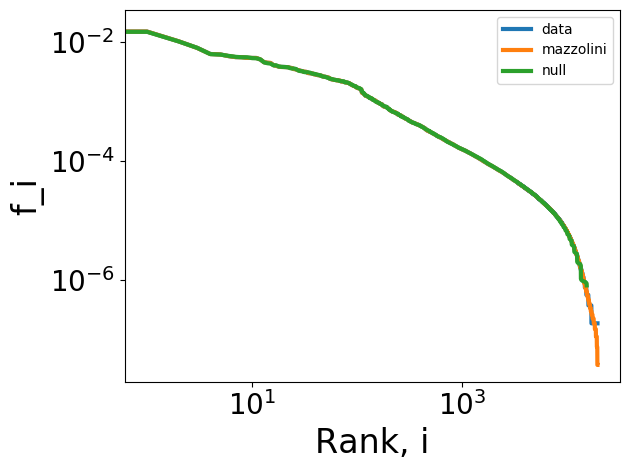

In [79]:
fig, ax = PyPlot.subplots()
ax.plot(data["data"]["freq"].sort_values(ascending=false).values, label="data")
ax.plot(data["mazzolini"]["freq"].sort_values(ascending=false).values, label="mazzolini")
ax.plot(data["null_1"]["freq"].sort_values(ascending=false).values, label="null")

ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Rank, i", fontsize=24)
ax.set_ylabel("f_i", fontsize=24)
show()

fig.savefig("null_1_zipf.pdf")

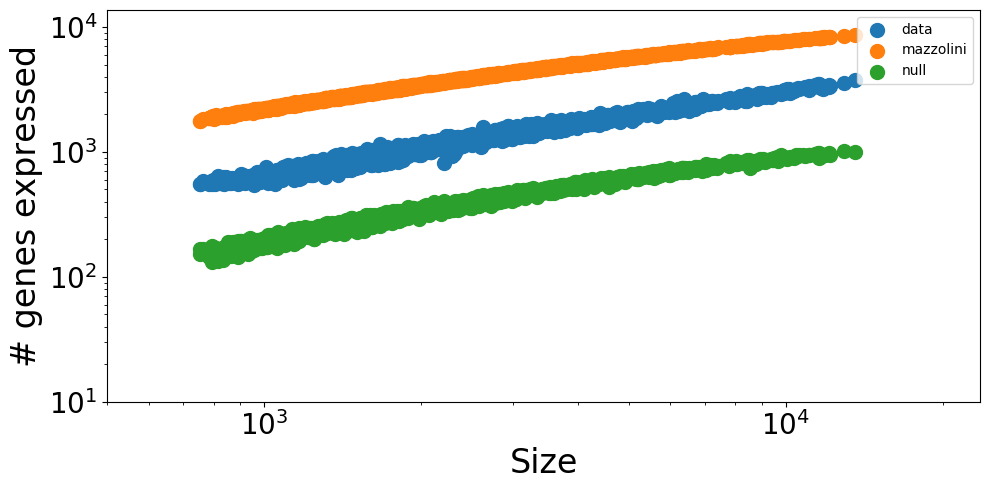

In [80]:
fig, ax = PyPlot.subplots(figsize=(10,5))
ax.scatter(data["data"]["M"].values, data["data"]["diffWords"].values, label="data")
ax.scatter(data["mazzolini"]["M"].values, data["mazzolini"]["diffWords"].values, label="mazzolini")
ax.scatter(data["null_1"]["M"].values, data["null_1"]["diffWords"].values, label="null")


ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(500,data["data"]["M"].max()+1e4)
ax.set_ylim(10,data["mazzolini"]["diffWords"].max()+5e3)

ax.set_xlabel("Size", fontsize=24)

ax.set_ylabel("# genes expressed", fontsize=24)
show()

fig.savefig("null_1_heaps.pdf")

In [13]:
for g in data["data"]["freq"].sort_values(ascending=false).index
    println(g)
end

Wap
Csn1s2a
Csn1s2b
Csn3
Csn2
Csn1s1
Glycam1
Wfdc18
Lalba
Trf
Fabp3
Igkc
Lao1
Igha
Cidea
Rpl41
Fth1
Qsox1
Mfge8
Folr1
Nupr1
Wfdc3
Thrsp
Rpl10
mt-Cytb
Ssr4
mt-Nd1
Clu
Mt1
Rpl13
Rpl32
Rps14
Dbi
Lcn2
mt-Co1
Cox6a1
Fkbp11
Rpl18a
mt-Rnr2
Jchain
Gpx1
Rps27l
Lpl
Rplp1
Ubb
Cox6b1
Ly6e
Cel
Rps26
Cox4i1
mt-Nd4
Rpl11
Plin2
Eif1
Tpt1
Cox8a
Mpc2
Cox7b
Rps24
Ndufb9
Rpl26
Krtcap2
Rps9
Rplp0
Rpl37
Rps11
Cox5a
Ndufv3
Slc25a5
Rps8
Rpl14
Rps15a
Tmsb4x
Rpl8
Rps27
Cox7a2
Rps2
mt-Nd2
Cd74
Atp5j
Rps29
Atp5g1
Cox6c
Ftl1
Olah
Prdx4
Rpl18
Scd1
Rpl37a
Ctsb
Rps12
Cst3
Rps27a
Tceal9
Sec61b
Rpl23
Rps3a1
Rpl38
Rabac1
Rpl4
Uqcrh
Uqcrq
Rps17
Map1lc3b
Rps13
Rplp2
Dap
Chchd2
Itm2b
Rpl36
Rps21
Npc2
Calm1
Rps19
Orm1
Rps28
Rps20
Rpl30
Rpl35a
Aldoc
Rpl31
Rps16
Rps5
Rps25
Gabarap
Rpl34
Serp1
Msrb1
Uqcrb
Selenop
Atp5j2
Gapdh
Rps3
Ndufb8
Rpl21
Rps7
Mdh1
Rpl35
Atp5o
Dad1
Ubc
Ndufa1
Sec11c
Abcg2
Rps4x
Gnas
Pigr
Hspa8
Tmbim6
Ldha
Rpl36al
Rpl7
Atp5b
Rpsa
Rpl17
P4hb
H3f3b
Cd36
Atp5d
Rpl19
Btn1a1
Rpl23a
Ceacam10
Uqcr10
Sparc
Rps15
N

In [202]:
integrals = []
tissues = (split(split(f,"data_")[2],"_data")[1] for f in readdir() if occursin(".pkl",f))
for tissue in tissues
    #print(tissue)
    integral=load_pickle("data_$(tissue)_data.pkl")["heaps_integral"][1]
    append!(integrals, integral::Float64)
end
integrals = DataFrames.DataFrame(data=integrals, index = [t for t in tissues])
sort!(integrals, rev=true)

,data,index
,Any,SubStrin…
1,2.13681e7,Liver
2,2.11916e7,Peripheral_Blood
3,2.101e7,Fetal-Liver
4,2.07862e7,Fetal_Brain
5,2.01059e7,MammaryGland.Virgin
6,1.98591e7,Placenta
7,1.87566e7,Trophoblast-Stem-Cell
8,1.85968e7,MammaryGland.Involution
9,1.49693e7,Stomach


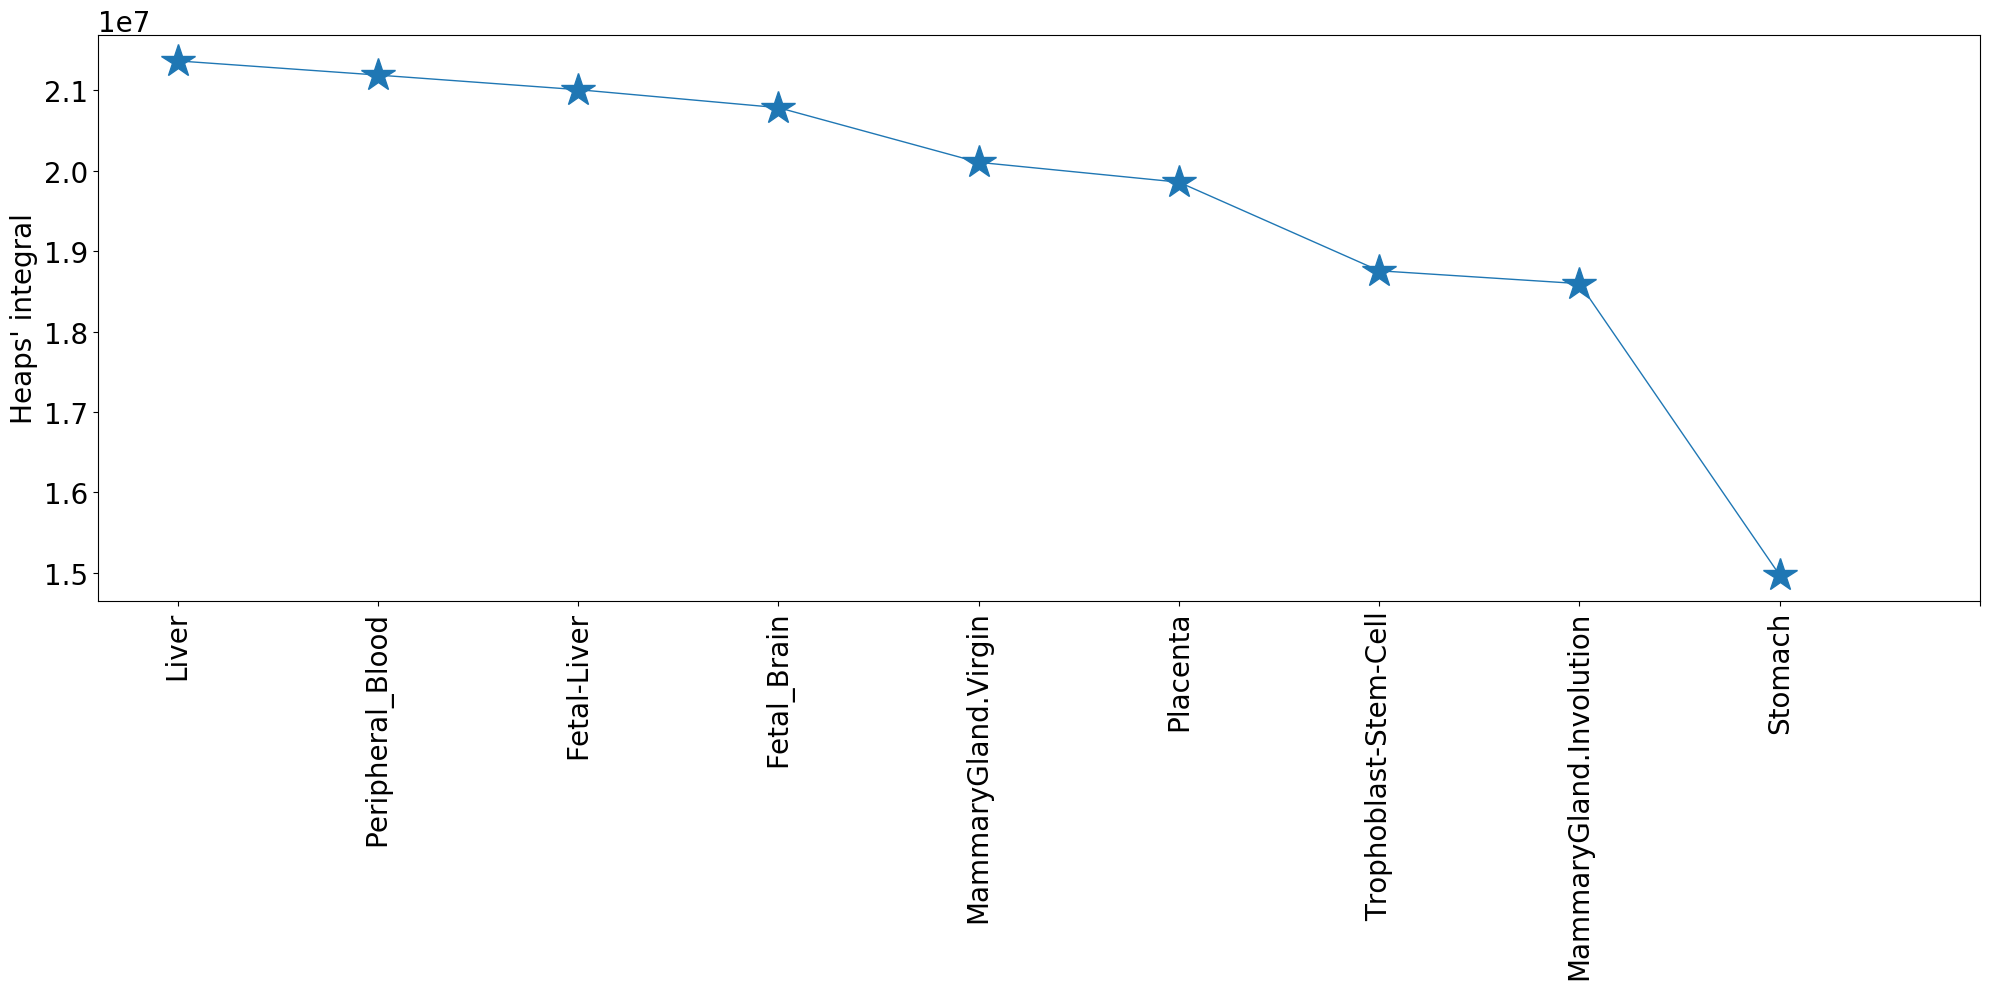

In [203]:
fig = PyPlot.figure(figsize=(20,10))
PyPlot.plot(integrals.data, marker="*", lw=1, ms=25)
locs, labels = xticks()
PyPlot.xticks(0:length(integrals.index), labels = integrals.index, rotation=90)
PyPlot.ylabel("Heaps' integral", fontsize=20)
fig.savefig("itegral_heapfs_scatter_plot.pdf")